In [13]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
import sys

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))

from preprocessing.data_loader import TCGADataLoader


In [41]:
# Load configuration
# Resolve to absolute path to avoid issues when passing to TCGADataLoader
config_path = Path('../config/config.yaml').resolve()
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

mutations_folder = Path(config['data']['mutation_path'])
print(f"Loading mutations from: {mutations_folder}")
print(f"Config path: {config_path}")


Loading mutations from: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\Data\tcga_xena_mutations
Config path: C:\Users\KerenYlab.MEDICINE\OneDrive - Technion\Asaf\Expression_to_Mutation\mutation_prediction\config\config.yaml


In [42]:
# Load mutation files with mc3.txt.gz format
full_mutation_files = [file for file in os.listdir(mutations_folder) if file.endswith('mc3.txt.gz')]

print(f"Found {len(full_mutation_files)} mutation files")
print(f"Sample files: {full_mutation_files[:5] if len(full_mutation_files) > 5 else full_mutation_files}")

cancer_df_list = []

for file in full_mutation_files:
    cancer = file.split('_')[0]
    file_path = os.path.join(mutations_folder, file)
    print(f"Loading {file} (cancer type: {cancer})...")
    
    # pandas automatically handles .gz compression
    cancer_df = pd.read_csv(file_path, sep='\t', compression='gzip')
    cancer_df['Cancer'] = cancer
    cancer_df_list.append(cancer_df)

cancer_df = pd.concat(cancer_df_list, ignore_index=True)
print(f"\nTotal mutations loaded: {len(cancer_df)}")
print(f"Columns: {cancer_df.columns.tolist()}")
print(f"\nFirst few rows:")
cancer_df.head()


Found 32 mutation files
Sample files: ['ACC_mc3.txt.gz', 'BLCA_mc3.txt.gz', 'BRCA_mc3.txt.gz', 'CESC_mc3.txt.gz', 'CHOL_mc3.txt.gz']
Loading ACC_mc3.txt.gz (cancer type: ACC)...
Loading BLCA_mc3.txt.gz (cancer type: BLCA)...
Loading BRCA_mc3.txt.gz (cancer type: BRCA)...
Loading CESC_mc3.txt.gz (cancer type: CESC)...
Loading CHOL_mc3.txt.gz (cancer type: CHOL)...
Loading COAD_mc3.txt.gz (cancer type: COAD)...
Loading DLBC_mc3.txt.gz (cancer type: DLBC)...
Loading ESCA_mc3.txt.gz (cancer type: ESCA)...
Loading GBM_mc3.txt.gz (cancer type: GBM)...
Loading HNSC_mc3.txt.gz (cancer type: HNSC)...
Loading KICH_mc3.txt.gz (cancer type: KICH)...
Loading KIRC_mc3.txt.gz (cancer type: KIRC)...
Loading KIRP_mc3.txt.gz (cancer type: KIRP)...
Loading LGG_mc3.txt.gz (cancer type: LGG)...
Loading LIHC_mc3.txt.gz (cancer type: LIHC)...
Loading LUAD_mc3.txt.gz (cancer type: LUAD)...
Loading LUSC_mc3.txt.gz (cancer type: LUSC)...
Loading MESO_mc3.txt.gz (cancer type: MESO)...
Loading OV_mc3.txt.gz (canc

,sample,chr,start,end,reference,alt,gene,effect,Amino_Acid_Change,DNA_VAF,SIFT,PolyPhen,Cancer
0,TCGA-OR-A5J1-01,10,88419681,88419681,G,A,OPN4,Missense_Mutation,p.G288D,0.07,tolerated(0.62),benign(0.02),ACC
1,TCGA-OR-A5J1-01,12,133360652,133360652,C,T,GOLGA3,Intron,NaN,0.27,NaN,NaN,ACC
2,TCGA-OR-A5J1-01,12,9760409,9760409,C,G,KLRB1,Missense_Mutation,p.E9D,0.41,tolerated(1),benign(0),ACC
3,TCGA-OR-A5J1-01,14,21991730,21991730,C,T,SALL2,Missense_Mutation,p.R711Q,0.47,deleterious(0),probably_damaging(0.997),ACC
4,TCGA-OR-A5J1-01,15,40587141,40587141,C,T,PLCB2,Silent,p.T634T,0.46,NaN,NaN,ACC


In [43]:
# Add 'A' to sample column (to match TCGA sample ID format)
if 'sample' in cancer_df.columns:
    cancer_df['sample'] = cancer_df['sample'] + 'A'
    print(f"Added 'A' suffix to sample IDs")
    print(f"Sample IDs example: {cancer_df['sample'].head().tolist()}")
else:
    print("Warning: 'sample' column not found. Available columns:", cancer_df.columns.tolist())


Added 'A' suffix to sample IDs
Sample IDs example: ['TCGA-OR-A5J1-01A', 'TCGA-OR-A5J1-01A', 'TCGA-OR-A5J1-01A', 'TCGA-OR-A5J1-01A', 'TCGA-OR-A5J1-01A']


In [44]:
def plot_mutations_per_sample(
    cancer_df,
    save_path=None,
    title="Mutations per sample by cancer type",
    xlabel="Cancer type",
    ylabel="Mean mutations per sample",
    figsize=(12, 6),
    log_scale=True,
    rotation=45,
    bar_kwargs=None
):
    """
    Plots mean mutations per sample by cancer type, with asymmetric error bars.
    Cancer types are sorted by median mutations per sample.

    Parameters:
        cancer_df (pd.DataFrame): DataFrame with at least 'Cancer' and 'sample' columns.
        save_path (str or None): If given, saves figure to this file instead of showing it.
        title (str): Plot title.
        xlabel (str): x-axis label.
        ylabel (str): y-axis label.
        figsize (tuple): Figure size.
        log_scale (bool): If True, use log scale for y-axis.
        rotation (int): Degree of rotation for x-axis tick labels.
        bar_kwargs (dict): Optional additional kwargs for plt.bar.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    mutations_per_sample = (
        cancer_df
        .groupby(['Cancer', 'sample'])
        .size()
        .reset_index(name='mutation_count')
    )

    # Compute stats by cancer
    mutation_stats = (
        mutations_per_sample
        .groupby('Cancer')['mutation_count']
        .agg(['mean', 'std'])
        .reset_index()
    )

    # Sort cancer types by median mutation count
    mutation_stats = mutation_stats.sort_values('mean', ascending=True)
    ordered_cancer_types = mutation_stats['Cancer'].tolist()

    # Reindex mutations_per_sample for sorting if needed in future
    # Prepare error bars as before
    means = mutation_stats['mean'].values
    stds = mutation_stats['std'].values

    lower_err = np.minimum(stds, means)
    upper_err = stds
    yerr = np.vstack([lower_err, upper_err])

    if bar_kwargs is None:
        bar_kwargs = {}

    plt.figure(figsize=figsize)
    plt.bar(
        mutation_stats['Cancer'],
        means,
        yerr=yerr,
        capsize=5,
        alpha=0.7,
        edgecolor='black',
        **bar_kwargs
    )
    plt.ylabel(ylabel)
    if log_scale:
        plt.yscale('log')
    plt.xlabel(xlabel)
    plt.title(title)
    plt.xticks(rotation=rotation, ha='right')
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()


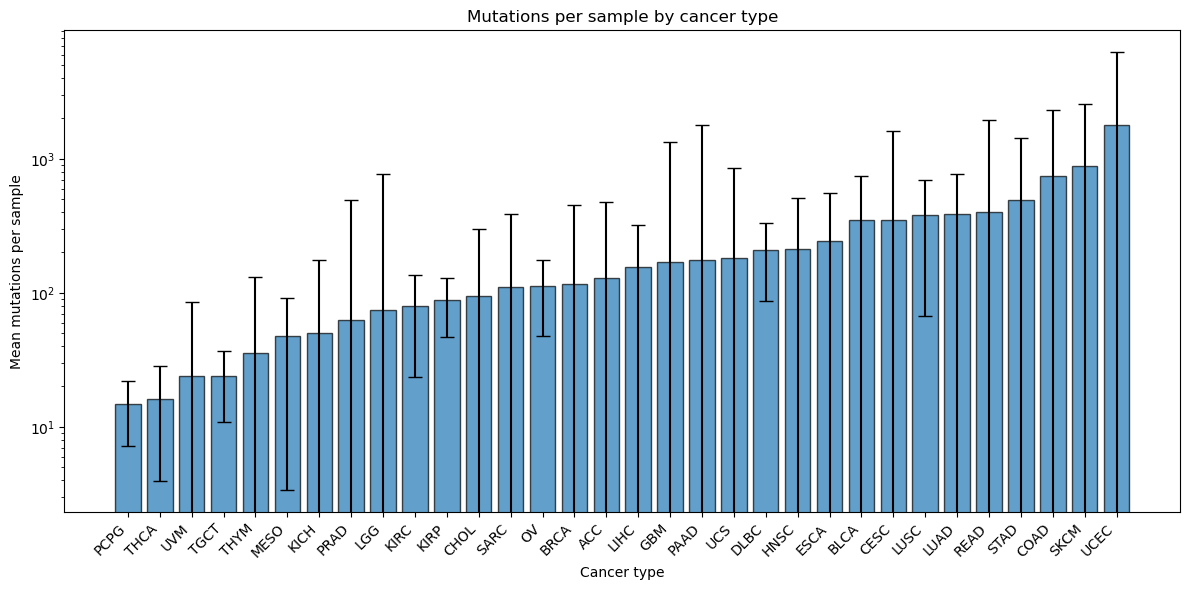

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate mutations per sample
if 'sample' in cancer_df.columns and 'Cancer' in cancer_df.columns:
    plot_mutations_per_sample(cancer_df)
   

In [46]:
# Categorize mutations as coding vs non-coding
mutation_category_map = {
    "Missense_Mutation": "coding",
    "Frame_Shift_Del": "coding",
    "Nonsense_Mutation": "coding",
    "Frame_Shift_Ins": "coding",
    "In_Frame_Del": "coding",
    "Translation_Start_Site": "coding",
    "Nonstop_Mutation": "coding",
    "In_Frame_Ins": "coding",
    "large deletion": "non-coding",  # assuming TCGA large deletions in coding regions
    "Silent": "non-coding",
    "Splice_Site": "coding",  # splicing of coding exons
    "3'UTR": "non-coding",
    "Intron": "non-coding",
    "5'UTR": "non-coding",
    "RNA": "non-coding",
    "3'Flank": "non-coding",
    "5'Flank": "non-coding"
}

if 'effect' in cancer_df.columns:
    cancer_df["coding_status"] = cancer_df["effect"].map(mutation_category_map)
    
    # Show distribution of mutation types
    print("Mutation type distribution:")
    print(cancer_df['coding_status'].value_counts())
    print(f"\nUnique mutation effects: {cancer_df['effect'].unique()}")
    
    # Check for unmapped mutation types
    unmapped = cancer_df[cancer_df['coding_status'].isna()]
    if len(unmapped) > 0:
        print(f"\nWarning: {len(unmapped)} mutations with unmapped effect types:")
        print(unmapped['effect'].value_counts())
    
    # Filter for coding mutations only
    coding_cancer_df = cancer_df[cancer_df['coding_status'] == 'coding'].copy()
    
    print(f"\nTotal mutations: {len(cancer_df)}")
    print(f"Coding mutations: {len(coding_cancer_df)} ({100*len(coding_cancer_df)/len(cancer_df):.1f}%)")
    print(f"Non-coding mutations: {len(cancer_df) - len(coding_cancer_df)} ({100*(len(cancer_df) - len(coding_cancer_df))/len(cancer_df):.1f}%)")

else:
    print("Warning: 'effect' column not found. Cannot categorize mutations.")
    print("Available columns:", cancer_df.columns.tolist())


Mutation type distribution:
coding_status
coding        1808264
non-coding    1099071
Name: count, dtype: int64

Unique mutation effects: ['Missense_Mutation' 'Intron' 'Silent' 'Frame_Shift_Del' "3'UTR"
 'Splice_Site' 'Nonsense_Mutation' 'RNA' "5'UTR" "5'Flank"
 'Frame_Shift_Ins' 'In_Frame_Del' "3'Flank" 'In_Frame_Ins'
 'Nonstop_Mutation' 'Translation_Start_Site' 'large deletion']

Total mutations: 2907335
Coding mutations: 1808264 (62.2%)
Non-coding mutations: 1099071 (37.8%)


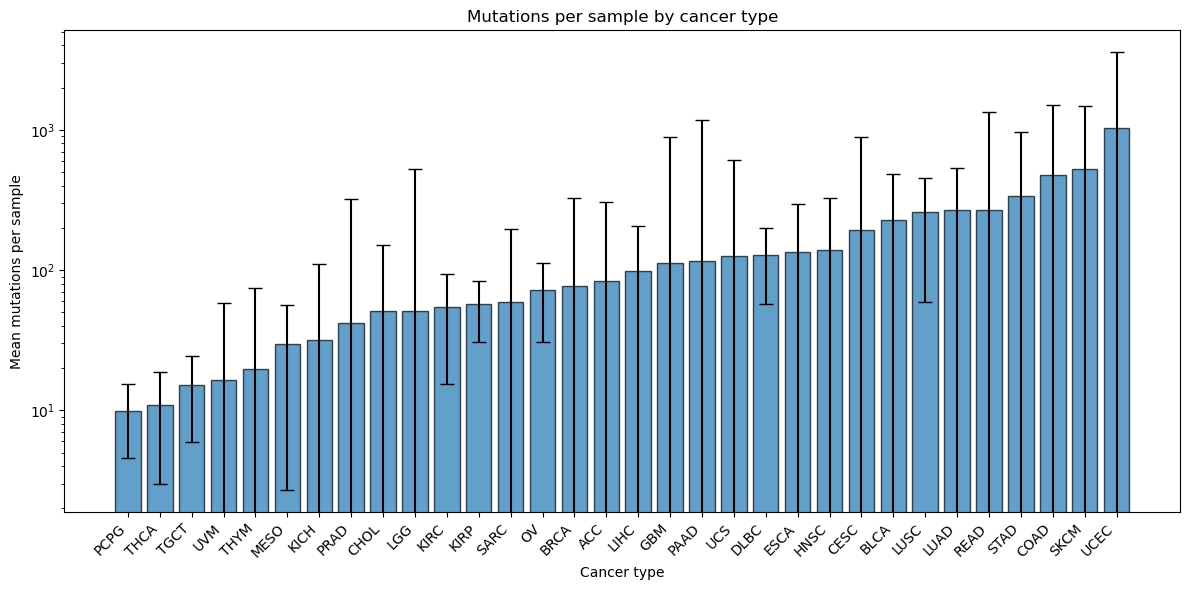

In [47]:
plot_mutations_per_sample(coding_cancer_df)

In [48]:
# Calculate TMB (Tumor Mutational Burden) - total coding mutations per sample
# TMB is typically calculated as the number of mutations per megabase (Mb) of sequenced DNA
# Here we calculate total coding mutation count per sample (which is a common TMB metric)
# Note: cancer_df now contains only coding mutations after filtering in the previous cell

if 'sample' in cancer_df.columns:
    # Count mutations per sample
    tmb_df = cancer_df.groupby('sample').size().reset_index(name='mutation_count')
    tmb_df = tmb_df.sort_values('mutation_count', ascending=False)
    
    # Add cancer type information
    sample_cancer_map = cancer_df[['sample', 'Cancer']].drop_duplicates().set_index('sample')['Cancer']
    tmb_df['Cancer'] = tmb_df['sample'].map(sample_cancer_map)
    
    print(f"TMB calculated for {len(tmb_df)} samples")
    print(f"\nTMB statistics:")
    print(tmb_df['mutation_count'].describe())
    print(f"\nTop 10 samples by mutation count:")
    print(tmb_df.head(10))

else:
    print("Error: Cannot calculate TMB without 'sample' column")


TMB calculated for 9104 samples

TMB statistics:
count     9104.000000
mean       319.346990
std       1282.771662
min          1.000000
25%         40.000000
50%         87.000000
75%        205.000000
max      27493.000000
Name: mutation_count, dtype: float64

Top 10 samples by mutation count:
                sample  mutation_count Cancer
6098  TCGA-FW-A3R5-06A           27493   SKCM
5563  TCGA-EO-A22U-01A           25534   UCEC
5982  TCGA-FI-A2D5-01A           24192   UCEC
2175  TCGA-AX-A2HC-01A           23087   UCEC
5560  TCGA-EO-A22R-01A           22823   UCEC
2374  TCGA-B5-A3FC-01A           22662   UCEC
4965  TCGA-E6-A1LX-01A           22062   UCEC
6733  TCGA-IB-7651-01A           21500   PAAD
2065  TCGA-AP-A1DV-01A           21329   UCEC
2162  TCGA-AX-A1CE-01A           20186   UCEC


In [49]:
# Load expression data for TMB prediction
data_loader = TCGADataLoader(config_path=str(config_path), use_cache=True)

print("Loading expression data...")
expression_data = data_loader.load_expression_data(load_tpm=False)

print(f"Expression data shape: {expression_data.shape}")
print(f"Expression samples: {len(expression_data)}")
print(f"Expression features: {len(expression_data.columns)}")


Loading expression data...
Expression data shape: (10980, 19992)
Expression samples: 10980
Expression features: 19992


In [50]:
# Align expression data with TMB data
if 'sample' in coding_cancer_df.columns:
    # Get common samples
    expression_samples = set(expression_data.index)
    tmb_samples = set(tmb_df['sample'])
    common_samples = expression_samples.intersection(tmb_samples)
    
    print(f"Expression samples: {len(expression_samples)}")
    print(f"TMB samples: {len(tmb_samples)}")
    print(f"Common samples: {len(common_samples)}")
    
    # Filter to common samples
    expression_aligned = expression_data.loc[list(common_samples)]
    tmb_aligned = tmb_df[tmb_df['sample'].isin(common_samples)].set_index('sample')
    tmb_aligned = tmb_aligned.loc[expression_aligned.index, 'mutation_count']
    
    print(f"\nAligned data:")
    print(f"Expression shape: {expression_aligned.shape}")
    print(f"TMB shape: {tmb_aligned.shape}")
    print(f"\nTMB distribution for aligned samples:")
    print(tmb_aligned.describe())
else:
    print("Error: Cannot align data without 'sample' column")


Expression samples: 10980
TMB samples: 9104
Common samples: 8585

Aligned data:
Expression shape: (8585, 19992)
TMB shape: (8585,)

TMB distribution for aligned samples:
count     8585.000000
mean       326.874665
std       1309.752846
min          1.000000
25%         39.000000
50%         88.000000
75%        212.000000
max      27493.000000
Name: mutation_count, dtype: float64


In [ ]:
# Prepare data for TMB prediction (regression task)
# X: expression data, y: TMB (mutation count)

if 'sample' in cancer_df.columns and 'common_samples' in locals() and len(common_samples) > 0:
    X = expression_aligned.values
    y = tmb_aligned.values
    
    print(f"Data prepared for TMB prediction:")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"y range: [{y.min():.0f}, {y.max():.0f}]")
    print(f"y mean: {y.mean():.2f}, median: {np.median(y):.2f}")
    
    # You can now use X and y for TMB prediction models
    # Example: train a regression model to predict TMB from expression data
    print(f"\nReady for model training!")
    print(f"Use X (expression features) to predict y (TMB/mutation count)")
else:
    print("Error: Data not properly aligned. Please run previous cells first.")
